# Function Importing & Prepare Data

In [248]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import itertools
import matplotlib
import os
import keras
from category_encoders.target_encoder import TargetEncoder
from sklearn.preprocessing import FunctionTransformer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import StratifiedShuffleSplit, GridSearchCV, RandomizedSearchCV, cross_validate
from sklearn.linear_model import SGDClassifier
from sklearn.kernel_approximation import RBFSampler
from sklearn.metrics import accuracy_score, average_precision_score, f1_score, precision_score, recall_score, balanced_accuracy_score, roc_auc_score, confusion_matrix
from sklearn.utils.fixes import loguniform
from sklearn.neural_network import MLPClassifier
from funcsigs import signature
from sklearn.model_selection import train_test_split
from sklearn.metrics import make_scorer
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Dropout

In [497]:
def split_dataset(data, preprocessor, random_state=82):
    """
    Split dataset into train, test and validation sets using preprocessor.
    Because the random state of validation set is not specified, the validation set will be different each time when the function is called.

    Parameters
    ----------
        data : DataFrame

        preprocessor : Pipeline

    Returns
    -------
        datasets : tuple

    Examples
    --------
        from sklearn.preprocessing import OrdinalEncoder
        data = import_dataset("../data/BankMarketing.csv").interpolate(method="pad").loc[:, ["job", "education", "y"]]
        # To unpack all train, test, and validation sets 
        X_train, y_train, X_test, y_test, X_ttrain, y_ttrain, X_validate, y_validate = split_dataset(data, OrdinalEncoder())
        # To unpack train and test sets.
        X_train, y_train, X_test, y_test, *other_sets = split_dataset(data, OrdinalEncoder())
        # To unpack test and validation set
        *other_sets, X_test, y_test, X_ttrain, y_ttrain, X_validate, y_validate = split_dataset(data, OrdinalEncoder())
        # To unpack only train set.
        X_train, y_train, *other_sets = split_dataset(data, OneHotEncoder())
    """
    train_test_split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=random_state)
    for train_index, test_index in train_test_split.split(data.drop("y", axis=1), data["y"]):
        train_set = data.loc[train_index].reset_index(drop=True)
        test_set = data.loc[test_index].reset_index(drop=True)

    y_train = train_set["y"].astype("int").to_numpy()
    y_test = test_set["y"].astype("int").to_numpy()
    X_train = preprocessor.fit_transform(train_set, y_train)
    X_test = preprocessor.transform(test_set)
        
    train_validate_split = StratifiedShuffleSplit(n_splits=1, test_size=0.2)
    for ttrain_index, validate_index in train_validate_split.split(X_train, y_train):
        ttrain_set = train_set.loc[ttrain_index].reset_index(drop=True)
        validate_set = train_set.loc[validate_index].reset_index(drop=True)
    
    y_ttrain = ttrain_set["y"].astype("int").to_numpy()
    y_validate = validate_set["y"].astype("int").to_numpy()
    X_ttrain = preprocessor.fit_transform(ttrain_set, y_ttrain)
    X_validate = preprocessor.transform(validate_set)
    
    if isinstance(X_train, pd.DataFrame):
        X_train = X_train.to_numpy()
        X_test = X_test.to_numpy()
        X_ttrain = X_ttrain.to_numpy()
        X_validate = X_validate.to_numpy()

    return (X_train, y_train, X_test, y_test, X_ttrain, y_ttrain, X_validate, y_validate)

In [498]:
def import_dataset(filename):
    """
    Import the dataset from the path.

    Parameters
    ----------
        filename : str
            filename with path

    Returns
    -------
        data : DataFrame

    Examples
    --------
        bank_mkt = import_dataset("../data/BankMarketing.csv")
    """
    bank_mkt = pd.read_csv(filename,
                           na_values=["unknown", "nonexistent"],
                           true_values=["yes", "success"],
                           false_values=["no", "failure"])
    # Treat pdays = 999 as missing values
    bank_mkt["pdays"] = bank_mkt["pdays"].replace(999, pd.NA)
    # Convert types, "Int64" is nullable integer data type in pandas
    bank_mkt = bank_mkt.astype(dtype={"age": "Int64",
                                      "job": "category",
                                      "marital": "category",
                                      "education": "category",
                                      "default": "boolean",
                                      "housing": "boolean",
                                      "loan": "boolean",
                                      "contact": "category",
                                      "month": "category",
                                      "day_of_week": "category",
                                      "duration": "Int64",
                                      "campaign": "Int64",
                                      "pdays": "Int64",
                                      "previous": "Int64",
                                      "poutcome": "boolean",
                                      "y": "boolean"})
    # Drop 12 duplicated rows
    bank_mkt = bank_mkt.drop_duplicates().reset_index(drop=True)
    # reorder categorical data
    bank_mkt["education"] = bank_mkt["education"].cat.reorder_categories(["illiterate", "basic.4y", "basic.6y", "basic.9y", "high.school", "professional.course", "university.degree"], ordered=True)
    bank_mkt["month"] = bank_mkt["month"].cat.reorder_categories(["mar", "apr", "jun", "jul", "may", "aug", "sep", "oct", "nov", "dec"], ordered=True)
    bank_mkt["day_of_week"] = bank_mkt["day_of_week"].cat.reorder_categories(["mon", "tue", "wed", "thu", "fri"], ordered=True)
    return bank_mkt

In [499]:
def benchmark(data, preprocessor, clf):
    """
    Benchmark preprocessor and clf's performance on train, validation and test sets. 
    All the data transformation should be handled by preprocessor and estimation should be handled by clf.
    
    Parameters
    ----------
        data : DataFrame
        
        preprocessor : Pipeline
        
        clf : estimator
        
        name : str, default = None
        
        compare_to: DataFrame, default = None
        
    """
    X_train, y_train, X_test, y_test, X_ttrain, y_ttrain, X_validate, y_validate = split_dataset(data, preprocessor)
    X_sets = [X_ttrain, X_validate, X_test]
    y_sets = [y_ttrain, y_validate, y_test]
    
    metric_names = ["TNR", "TPR", "bACC", "ROC", "REC", "PRE", "AP"]
    set_names = ["Train", "Validate", "Test"]
    metric_df = pd.DataFrame(index=metric_names, columns=set_names)
    
    try:
        clf.fit(X_ttrain, y_ttrain, eval_set=(X_validate, y_validate), verbose=False)
    except (ValueError, TypeError):
        clf.fit(X_ttrain, y_ttrain)
        
    for name, X, y in zip(set_names, X_sets, y_sets):
        # Re-fit model on train set before test set evaluation except CatBoost
        if name == "Test":
            try:
                clf.fit(X_ttrain, y_ttrain, eval_set=(X_validate, y_validate), verbose=False)
            except (ValueError, TypeError):
                clf.fit(X_train, y_train)
                
        y_pred = clf.predict(X)
        
        try:
            y_score = clf.decision_function(X)
        except AttributeError:
            y_score = clf.predict_proba(X)[:, 1]
            
        metrics = [recall_score(y, y_pred, pos_label=0),
                   recall_score(y, y_pred),
                   balanced_accuracy_score(y, y_pred),
                   roc_auc_score(y, y_score),
                   recall_score(y, y_pred),
                   precision_score(y, y_pred),
                   average_precision_score(y, y_score)]
        metric_df[name] = metrics
        
    return metric_df

In [500]:
def cat_encode(X,
               drop=["duration", "y"],
               cut=None,
               cyclic=None,
               target=None):
    """
    Encode and transform categorical data into numerical values.
    
    Parameters
    ----------
        X : DataFrame
        
        drop : list, default = ["duration", "y"]
        
        cut : list
        
        cyclic : list
        
        target : list
    
    Returns
    -------
        X : DataFrame

    Examples
    --------
    bank_mkt = import_dataset("../data/BankMarketing.csv")
    X = cat_encode(bank_mkt)
    """
    X = X.copy()
    
    # `month` will be encoded to the corresponding number, e.g. "mar" -> 3.
    month_map = {"mar": 3,
                 "apr": 4,
                 "may": 5,
                 "jun": 6,
                 "jul": 7,
                 "aug": 8,
                 "sep": 9,
                 "oct": 10,
                 "nov": 11,
                 "dec": 12}
    X["month"] = X["month"].replace(month_map).astype("Int64")
    
    if cut != None:
        if "pdays" in cut:
            X["pdays"] = X["pdays"].fillna(-1)
            # Clients who have been contacted but do not have pdays record
            X.loc[X["pdays"].isna() & X["poutcome"].notna(), "pdays"] = 999
            # Cut pdays into categories
            X["pdays"] = pd.cut(X["pdays"], [0, 3, 5, 10, 15, 30, 1000], labels=[3, 5, 10, 15, 30, 1000], include_lowest=True).astype("Int64")
    else:
        # Fill missing values in pdays as 999
        X["pdays"] = X["pdays"].fillna(999)
    
    if cyclic != None:
        if "month" in cyclic:
            X['month_sin'] = np.sin(2 * np.pi * X["month"]/12)
            X['month_cos'] = np.cos(2 * np.pi * X["month"]/12)
            X = X.drop("month", axis=1)
        if "day_of_week" in cyclic:
            X["day_of_week"] = X["day_of_week"].cat.codes
            X['day_sin'] = np.sin(2 * np.pi * X["day_of_week"]/5)
            X['day_cos'] = np.cos(2 * np.pi * X["day_of_week"]/5)
            X = X.drop("day_of_week", axis=1)
    
    # Transform target encoded feature as str
    if target != None:
        X[target] = X[target].astype("str")
        
    # Drop features
    X = X.drop(drop, axis=1)
    
    # Other categorical features will be coded as its order in pandas categorical index
    X = X.apply(lambda x: x.cat.codes if pd.api.types.is_categorical_dtype(x) else (x.astype("Int64") if pd.api.types.is_bool_dtype(x) else x))
    
    # Fill missing values as -1
    X = X.fillna(-1)
    
    return X

In [501]:
bank_mkt = import_dataset("/Users/alex/Desktop/Data Anal/ML/Group Project/BankMarketing.csv")

In [502]:
from sklearn.pipeline import make_pipeline
cat_encoder = FunctionTransformer(cat_encode)

freq_features = ["job", "marital", "education", "default", "housing", "loan"]

freq_imputer = ColumnTransformer([
    ("freq_imputer", SimpleImputer(missing_values=-1, strategy="most_frequent"), freq_features)
], remainder="passthrough")

freq_encoder = make_pipeline(cat_encoder, freq_imputer)

In [503]:
X_train, y_train, X_test, y_test, X_ttrain, y_ttrain, X_validate, y_validate = split_dataset(bank_mkt, freq_encoder)

# Train/ Test / Validate without Tuning

In [94]:
mlp=MLPClassifier(solver ="lbfgs",random_state=42,max_iter=1000)
benchmark(bank_mkt, freq_encoder, mlp)

,Train,Validate,Test
TNR,0.990591,0.990250,0.986180
TPR,0.188953,0.192722,0.181034
bACC,0.589772,0.591486,0.583607
ROC,0.758686,0.785037,0.770525
REC,0.188953,0.192722,0.181034
PRE,0.718310,0.715000,0.624535
AP,0.419627,0.436628,0.410457


# GridsearchCV

In [150]:
mlp=MLPClassifier(random_state=42,max_iter=1000)

param_grid ={
    'solver':['lbfgs', 'sgd', 'adam'],
    'learning_rate':["constant","invscaling","adaptive"],
    'hidden_layer_sizes':[(100,),(200,),(20,5,),(10,5,),(100,50,25,)],
    'alpha':[0.0,0.001,0.01],
    'activation' :["logistic","relu","tanh"] }

grid_search = GridSearchCV(estimator=mlp,
                          param_grid=param_grid,
                          scoring = "average_precision",
                          return_train_score=True,
                          cv =2,
                          n_jobs=-1) 
       
grid_fit = grid_search.fit(X_train, y_train)
grid_results = grid_search.cv_results_
grid_best_params = grid_search.best_params_
grid_best_score = grid_search.best_score_

print(f"best parameters found: {grid_best_params}, with mean test score: {grid_best_score}")

best parameters found: {'activation': 'relu', 'alpha': 0.01, 'hidden_layer_sizes': (100,), 'learning_rate': 'constant', 'solver': 'lbfgs'}, with mean test score: 0.4208468058986027


In [153]:
mlp_trained=MLPClassifier(solver ="lbfgs",
                          random_state=42,
                          max_iter=1000,
                          activation = 'relu',
                          alpha = 0.01,
                          hidden_layer_sizes = (100,),
                          learning_rate = 'constant')

benchmark(bank_mkt, freq_encoder, mlp_trained)

,Train,Validate,Test
TNR,0.989864,0.988026,0.986590
TPR,0.195352,0.207547,0.193966
bACC,0.592608,0.597787,0.590278
ROC,0.763937,0.762834,0.771836
REC,0.195352,0.207547,0.193966
PRE,0.709914,0.687500,0.647482
AP,0.421345,0.438027,0.415162


# Keras

In [692]:
bank_mkt = import_dataset("/Users/alex/Desktop/Data Anal/ML/Group Project/BankMarketing.csv")

In [693]:
from sklearn.pipeline import make_pipeline
cat_encoder = FunctionTransformer(cat_encode)

freq_features = ["job", "marital", "education", "default", "housing", "loan"]

freq_imputer = ColumnTransformer([
    ("freq_imputer", SimpleImputer(missing_values=-1, strategy="most_frequent"), freq_features)
], remainder="passthrough")

freq_encoder = make_pipeline(cat_encoder, freq_imputer)

In [694]:
X_train, y_train, X_test, y_test, X_ttrain, y_ttrain, X_validate, y_validate = split_dataset(bank_mkt, freq_encoder)

In [695]:
X_train = np.asarray(X_train).astype('float32')
X_test = np.asarray(X_test).astype('float32')
y_train = np.asarray(y_train).astype('float32')
y_test = np.asarray(y_test).astype('float32')
X_ttrain = np.asarray(X_ttrain).astype('float32')
y_ttrain = np.asarray(y_ttrain).astype('float32')
X_validate = np.asarray(X_validate).astype('float32')
y_validate = np.asarray(y_validate).astype('float32')

Metrics in Keras:
    
https://machinelearningmastery.com/custom-metrics-deep-learning-keras-python/

Optimizer：

https://blog.csdn.net/weixin_40170902/article/details/80092628

Batch/Epochs/Iteration：

如果Batch_Size过小，训练数据就会非常难收敛，从而导致underfitting；

增大Batch_Size,相对处理速度加快，所需内存容量增加（epoch的次数需要增加以达到最好的结果）

Batch_Size的正确选择是为了在内存效率和内存容量之间寻找最佳平衡。

1个epoch指用训练集中的全部样本训练一次

随着epoch数量增加，神经网络中的权重的更新次数也在增加，曲线从欠拟合变得过拟合

1个iteration即迭代一次，也就是用batchsize个样本训练一次。



## Keras model with validation

In [704]:
model = Sequential()
model.add(Dropout(0.5, input_shape=(19,)))
model.add(Dense(5, activation='relu'))
model.add(Dropout(0.8))
#model.add(Dense(5, activation='relu'))
#model.add(Dropout(0.8))
model.add(Dense(1, activation='sigmoid'))
model.compile(loss='binary_crossentropy', 
              optimizer='rmsprop', 
              metrics=['binary_accuracy'])

In [705]:
history = model.fit(X_ttrain, 
                    y_ttrain,
                    validation_data = (X_validate,y_validate), 
                    epochs=25, 
                    batch_size=500)

Epoch 1/25
53/53 [==============================] - 0s 3ms/step - loss: 1235.0629 - binary_accuracy: 0.7450 - val_loss: 24.9997 - val_binary_accuracy: 0.8981
Epoch 2/25
53/53 [==============================] - 0s 2ms/step - loss: 889.4126 - binary_accuracy: 0.7937 - val_loss: 68.4195 - val_binary_accuracy: 0.8874
Epoch 3/25
53/53 [==============================] - 0s 2ms/step - loss: 684.8979 - binary_accuracy: 0.8124 - val_loss: 85.5190 - val_binary_accuracy: 0.8874
Epoch 4/25
53/53 [==============================] - 0s 1ms/step - loss: 465.5873 - binary_accuracy: 0.8256 - val_loss: 81.2773 - val_binary_accuracy: 0.8874
Epoch 5/25
53/53 [==============================] - 0s 2ms/step - loss: 301.1856 - binary_accuracy: 0.8328 - val_loss: 69.7759 - val_binary_accuracy: 0.8874
Epoch 6/25
53/53 [==============================] - 0s 1ms/step - loss: 187.7012 - binary_accuracy: 0.8508 - val_loss: 52.8702 - val_binary_accuracy: 0.8874
Epoch 7/25
53/53 [==============================] - 0s 2m

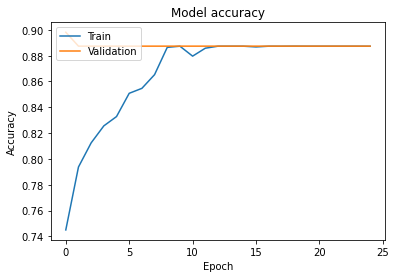

In [706]:
plt.plot(history.history['binary_accuracy'])
plt.plot(history.history['val_binary_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

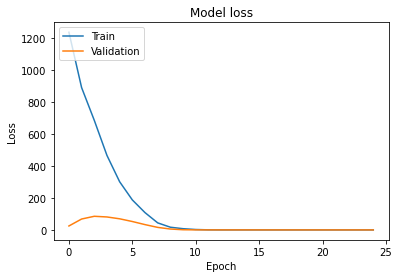

In [707]:
plt.plot(history.history['loss']) 
plt.plot(history.history['val_loss']) 
plt.title('Model loss') 
plt.ylabel('Loss') 
plt.xlabel('Epoch') 
plt.legend(['Train', 'Validation'], loc='upper left') 
plt.show()

## Keras_test_accuracy

In [712]:
_, accuracy = model.evaluate(x=X_test, y=y_test)
print('Accuracy: %.2f' % (accuracy*100))

258/258 [==============================] - 0s 624us/step - loss: 0.3774 - binary_accuracy: 0.8873
Accuracy: 88.73
